In [3]:
import pandas as pd
import mhcflurry
from mhcflurry import Class1AffinityPredictor
from mhcflurry import scoring
from mhcflurry import select_allele_specific_models_command
from mhcflurry.downloads import get_path
import mhcnames
from mhcflurry import Class1NeuralNetwork
import sklearn
import scipy
from sklearn.cross_validation import train_test_split
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
#Predictor with multiple layer
predictor = Class1AffinityPredictor.load()

In [5]:
#Supported allele from this predictor
supported_A = predictor.supported_alleles

In [6]:
#predict with predictor
predictor.predict(allele="HLA-A0201", peptides=["SIINFEKL", "SIINFEQL"])

/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


array([4571.98327319, 3583.33113994])

In [7]:
#predict multiple alleles, the length of peptides need to be the same as allele
predictor.predict_to_dataframe(allele="HLA-A0201", peptides=["SIINFEKL", "SIINFEQL"])

,peptide,allele,prediction,prediction_low,prediction_high,prediction_percentile
0,SIINFEKL,HLA-A0201,4571.983273,2093.541620,11331.827657,6.381625
1,SIINFEQL,HLA-A0201,3583.331140,1388.942403,10621.888497,5.284625


In [8]:
#get data path
data_path = get_path("data_curated", "curated_training_data.no_mass_spec.csv.bz2")
data_path

'/Users/nickiblumenfeld/Library/Application Support/mhcflurry/4/1.2.0/data_curated/curated_training_data.no_mass_spec.csv.bz2'

In [9]:
#read training data
df = pd.read_csv(data_path)

In [10]:
#only select peptide between 8 to 15
df = df.loc[(df.peptide.str.len() >= 8) & (df.peptide.str.len() <= 15)]
df.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
0,BoLA-1*21:01,AENDTLVVSV,7817.0,=,quantitative,Barlow - purified MHC/competitive/fluorescence,BoLA-1*02101
1,BoLA-1*21:01,NQFNGGCLLV,1086.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-1*02101
2,BoLA-2*08:01,AAHCIHAEW,21.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
3,BoLA-2*08:01,AAKHMSNTY,1299.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
4,BoLA-2*08:01,DSYAYMRNGW,2.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801


In [11]:
#select training data
single_allele_train_data = df.loc[df.allele == "HLA-B*57:01"].sample(100)
single_allele_train_data.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
205162,HLA-B*57:01,PHAATIRVL,20000.0,=,quantitative,Buus - purified MHC/direct/fluorescence,HLA-B*57:01
206044,HLA-B*57:01,WAIQCYTGV,20000.0,=,quantitative,Buus - purified MHC/competitive/fluorescence,HLA-B*57:01
203686,HLA-B*57:01,DHLTGRSCQ,70422.5,=,quantitative,- purified MHC/competitive/radioactivity,HLA-B*57:01
203730,HLA-B*57:01,DYNFVKQLF,78125.0,>,qualitative,kim2014,HLA-B*57:01
203935,HLA-B*57:01,FLILPQAKK,20000.0,=,quantitative,Buus - purified MHC/competitive/fluorescence,HLA-B*57:01


In [12]:
# try to generate a data set for prediction to output score auc etc. 
newd = df.loc[df.allele.isin(supported_A)]
newd

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
79,BoLA-6*13:01,AAVGYPKVKEEML,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301
80,BoLA-6*13:01,AGYPKVKEEML,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301
81,BoLA-6*13:01,AIMPKDIQL,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301
82,BoLA-6*13:01,ALFYKDGKL,1.000000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301
83,BoLA-6*13:01,ALYEKKLAL,1.000000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301
84,BoLA-6*13:01,AMKDRFQPL,4.300000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301
85,BoLA-6*13:01,APSRTEQTGV,5000.000000,>,qualitative,Srikumaran - cellular MHC/direct/fluorescence,BoLA-6*01301
86,BoLA-6*13:01,APVQSLIHSV,5000.000000,>,qualitative,Srikumaran - cellular MHC/direct/fluorescence,BoLA-6*01301
87,BoLA-6*13:01,AQRELFFTL,1.000000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301
88,BoLA-6*13:01,CVGYPKVKEEML,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301


In [21]:
# generate random sample
sample = newd
sample


,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
79,BoLA-6*13:01,AAVGYPKVKEEML,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301
80,BoLA-6*13:01,AGYPKVKEEML,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301
81,BoLA-6*13:01,AIMPKDIQL,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301
82,BoLA-6*13:01,ALFYKDGKL,1.000000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301
83,BoLA-6*13:01,ALYEKKLAL,1.000000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301
84,BoLA-6*13:01,AMKDRFQPL,4.300000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301
85,BoLA-6*13:01,APSRTEQTGV,5000.000000,>,qualitative,Srikumaran - cellular MHC/direct/fluorescence,BoLA-6*01301
86,BoLA-6*13:01,APVQSLIHSV,5000.000000,>,qualitative,Srikumaran - cellular MHC/direct/fluorescence,BoLA-6*01301
87,BoLA-6*13:01,AQRELFFTL,1.000000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301
88,BoLA-6*13:01,CVGYPKVKEEML,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301


In [22]:
#predict
p_result = predictor.predict_to_dataframe(alleles = sample['allele'], peptides=sample['peptide'])
p_result

,peptide,allele,prediction,prediction_low,prediction_high,prediction_percentile
0,AAVGYPKVKEEML,BoLA-6*13:01,3851.831837,46.867887,29891.088309,0.308625
1,AGYPKVKEEML,BoLA-6*13:01,602.596120,5.135985,29102.449955,0.025375
2,AIMPKDIQL,BoLA-6*13:01,154.216702,6.209612,4842.004053,0.004500
3,ALFYKDGKL,BoLA-6*13:01,333.033726,13.093043,10137.765523,0.011500
4,ALYEKKLAL,BoLA-6*13:01,112.718503,7.819027,10567.088915,0.003000
5,AMKDRFQPL,BoLA-6*13:01,28.882294,2.317477,748.982544,0.000125
6,APSRTEQTGV,BoLA-6*13:01,37471.626732,23221.899163,48905.805964,30.966500
7,APVQSLIHSV,BoLA-6*13:01,26420.863526,3261.892533,48778.364624,9.386875
8,AQRELFFTL,BoLA-6*13:01,40.404553,3.615345,1180.693874,0.000625
9,CVGYPKVKEEML,BoLA-6*13:01,10874.423657,1204.437499,38647.440188,1.539500


In [23]:
# output scores
score = scoring.make_scores(sample.measurement_value, p_result.prediction)
score

{'auc': 0.9416137334293158,
 'f1': 0.8110026889706498,
 'tau': 0.6022849212132855}

In [24]:
#run ppv
ppv = sklearn.metrics.precision_score(sample.measurement_value<=500, p_result.prediction<=500)
ppv

0.8278205427260711

In [25]:
sample.measurement_value<=500

79         True
80         True
81         True
82         True
83         True
84         True
85        False
86        False
87         True
88         True
89         True
90         True
91         True
92         True
93         True
94         True
95         True
96         True
97         True
98         True
99         True
100        True
101        True
102        True
103        True
104        True
105        True
106        True
107        True
108        True
          ...  
234137     True
234138    False
234139    False
234140    False
234141    False
234142    False
234143    False
234144    False
234145    False
234146    False
234147    False
234148     True
234149     True
234150    False
234151    False
234152    False
234153    False
234154     True
234155    False
234156    False
234157    False
234158    False
234159    False
234160     True
234161     True
234162     True
234163    False
234164    False
234165     True
234166    False
Name: measurement_value,

In [26]:
p_result.prediction<=500

0         False
1         False
2          True
3          True
4          True
5          True
6         False
7         False
8          True
9         False
10         True
11         True
12         True
13        False
14         True
15        False
16         True
17        False
18         True
19        False
20        False
21         True
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29         True
          ...  
228539    False
228540    False
228541    False
228542    False
228543    False
228544    False
228545    False
228546    False
228547    False
228548    False
228549    False
228550     True
228551     True
228552    False
228553    False
228554    False
228555    False
228556     True
228557    False
228558    False
228559    False
228560    False
228561    False
228562     True
228563     True
228564     True
228565    False
228566    False
228567    False
228568    False
Name: prediction, Length

In [27]:
scipy.stats.pearsonr(sample.measurement_value, p_result.prediction)

(0.23618387388910317, 0.0)

In [28]:
#Regenerate data for Fig. 1 using 15 alleles: 
supported_A = predictor.supported_alleles

sample1 = newd[newd.allele=="HLA-A*01:01"]
sample2 = newd[newd.allele=="HLA-A*02:01"]
sample3 = newd[newd.allele=="HLA-A*02:03"]
sample4 = newd[newd.allele=="HLA-A*02:07"]
sample5 = newd[newd.allele=="HLA-A*03:01"]
sample6 = newd[newd.allele=="HLA-A*24:02"]
sample7 = newd[newd.allele=="HLA-A*29:02"]
sample8 = newd[newd.allele=="HLA-A*31:01"]
sample9 = newd[newd.allele=="HLA-A*68:02"]
sample10 = newd[newd.allele=="HLA-B*35:01"]
sample11 = newd[newd.allele=="HLA-B*44:02"]
sample12 = newd[newd.allele=="HLA-B*44:03"]
sample13 = newd[newd.allele=="HLA-B*51:01"]
sample14 = newd[newd.allele=="HLA-B*54:01"]
sample15 = newd[newd.allele=="HLA-B*57:01"]


In [29]:
#predict
p_result1 = predictor.predict_to_dataframe(alleles = sample1['allele'], peptides=sample1['peptide'])
p_result2 = predictor.predict_to_dataframe(alleles = sample2['allele'], peptides=sample2['peptide'])
p_result3 = predictor.predict_to_dataframe(alleles = sample3['allele'], peptides=sample3['peptide'])
p_result4 = predictor.predict_to_dataframe(alleles = sample4['allele'], peptides=sample4['peptide'])
p_result5 = predictor.predict_to_dataframe(alleles = sample5['allele'], peptides=sample5['peptide'])
p_result6 = predictor.predict_to_dataframe(alleles = sample6['allele'], peptides=sample6['peptide'])
p_result7 = predictor.predict_to_dataframe(alleles = sample7['allele'], peptides=sample7['peptide'])
p_result8 = predictor.predict_to_dataframe(alleles = sample8['allele'], peptides=sample8['peptide'])
p_result9 = predictor.predict_to_dataframe(alleles = sample9['allele'], peptides=sample9['peptide'])
p_result10 = predictor.predict_to_dataframe(alleles = sample10['allele'], peptides=sample10['peptide'])
p_result11 = predictor.predict_to_dataframe(alleles = sample11['allele'], peptides=sample11['peptide'])
p_result12 = predictor.predict_to_dataframe(alleles = sample12['allele'], peptides=sample12['peptide'])
p_result13 = predictor.predict_to_dataframe(alleles = sample13['allele'], peptides=sample13['peptide'])
p_result14 = predictor.predict_to_dataframe(alleles = sample14['allele'], peptides=sample14['peptide'])
p_result15 = predictor.predict_to_dataframe(alleles = sample15['allele'], peptides=sample15['peptide'])

In [30]:
# output scores
score1 = scoring.make_scores(sample1.measurement_value, p_result1.prediction)
score2 = scoring.make_scores(sample2.measurement_value, p_result2.prediction)
score3 = scoring.make_scores(sample3.measurement_value, p_result3.prediction)
score4 = scoring.make_scores(sample4.measurement_value, p_result4.prediction)
score5 = scoring.make_scores(sample5.measurement_value, p_result5.prediction)
score6 = scoring.make_scores(sample6.measurement_value, p_result6.prediction)
score7 = scoring.make_scores(sample7.measurement_value, p_result7.prediction)
score8 = scoring.make_scores(sample8.measurement_value, p_result8.prediction)
score9 = scoring.make_scores(sample9.measurement_value, p_result9.prediction)
score10 = scoring.make_scores(sample10.measurement_value, p_result10.prediction)
score11 = scoring.make_scores(sample11.measurement_value, p_result11.prediction)
score12 = scoring.make_scores(sample12.measurement_value, p_result12.prediction)
score13 = scoring.make_scores(sample13.measurement_value, p_result13.prediction)
score14 = scoring.make_scores(sample14.measurement_value, p_result14.prediction)
score15 = scoring.make_scores(sample15.measurement_value, p_result15.prediction)

In [31]:
ppv1 = sklearn.metrics.precision_score(sample1.measurement_value<=500, p_result1.prediction<=500)
ppv2 = sklearn.metrics.precision_score(sample2.measurement_value<=500, p_result2.prediction<=500)
ppv3 = sklearn.metrics.precision_score(sample3.measurement_value<=500, p_result3.prediction<=500)
ppv4 = sklearn.metrics.precision_score(sample4.measurement_value<=500, p_result4.prediction<=500)
ppv5 = sklearn.metrics.precision_score(sample5.measurement_value<=500, p_result5.prediction<=500)
ppv6 = sklearn.metrics.precision_score(sample6.measurement_value<=500, p_result6.prediction<=500)
ppv7 = sklearn.metrics.precision_score(sample7.measurement_value<=500, p_result7.prediction<=500)
ppv8 = sklearn.metrics.precision_score(sample8.measurement_value<=500, p_result8.prediction<=500)
ppv9 = sklearn.metrics.precision_score(sample9.measurement_value<=500, p_result9.prediction<=500)
ppv10 = sklearn.metrics.precision_score(sample10.measurement_value<=500, p_result10.prediction<=500)
ppv11 = sklearn.metrics.precision_score(sample11.measurement_value<=500, p_result11.prediction<=500)
ppv12 = sklearn.metrics.precision_score(sample12.measurement_value<=500, p_result12.prediction<=500)
ppv13 = sklearn.metrics.precision_score(sample13.measurement_value<=500, p_result13.prediction<=500)
ppv14 = sklearn.metrics.precision_score(sample14.measurement_value<=500, p_result14.prediction<=500)
ppv15 = sklearn.metrics.precision_score(sample15.measurement_value<=500, p_result15.prediction<=500)

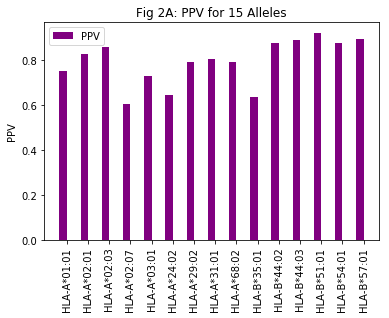

In [33]:
#Remake Fig. 2A

import numpy as np
import matplotlib.pyplot as plt

datax=["HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"]
datay=[ppv1, ppv2, ppv3, ppv4, ppv5, ppv6, ppv7, ppv8, ppv9, ppv10, ppv11, ppv12, ppv13, ppv14, ppv15]

ind = np.arange(len(datax))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, datay, width, color='Purple', label='PPV')

ax.set_ylabel('PPV')
ax.set_title('Fig 2A: PPV for 15 Alleles')
ax.set_xticks(ind)
ax.set_xticklabels(("HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"),rotation='vertical')
ax.legend()


In [34]:
print(ppv1,ppv2, ppv3, ppv4, ppv5,ppv6, ppv7, ppv8, ppv9, ppv10, ppv11, ppv12, ppv13, ppv14, ppv15)

0.7530364372469636 0.8302252883475262 0.8589705444808092 0.6046511627906976 0.7327141382868937 0.6466030989272944 0.7914831130690162 0.8054054054054054 0.7921928817451206 0.6388336646785951 0.8758620689655172 0.8931297709923665 0.9236641221374046 0.8762376237623762 0.8960396039603961


In [35]:
r1 = scipy.stats.pearsonr(sample1.measurement_value, p_result1.prediction)
r2 = scipy.stats.pearsonr(sample2.measurement_value, p_result2.prediction)
r3 = scipy.stats.pearsonr(sample3.measurement_value, p_result3.prediction)
r4 = scipy.stats.pearsonr(sample4.measurement_value, p_result4.prediction)
r5 = scipy.stats.pearsonr(sample5.measurement_value, p_result5.prediction)
r6 = scipy.stats.pearsonr(sample6.measurement_value, p_result6.prediction)
r7 = scipy.stats.pearsonr(sample7.measurement_value, p_result7.prediction)
r8 = scipy.stats.pearsonr(sample8.measurement_value, p_result8.prediction)
r9 = scipy.stats.pearsonr(sample9.measurement_value, p_result9.prediction)
r10 = scipy.stats.pearsonr(sample10.measurement_value, p_result10.prediction)
r11 = scipy.stats.pearsonr(sample11.measurement_value, p_result11.prediction)
r12 = scipy.stats.pearsonr(sample12.measurement_value, p_result12.prediction)
r13 = scipy.stats.pearsonr(sample13.measurement_value, p_result13.prediction)
r14 = scipy.stats.pearsonr(sample14.measurement_value, p_result14.prediction)
r15 = scipy.stats.pearsonr(sample15.measurement_value, p_result15.prediction)



In [36]:
#Form arrays for Fig. 2B
kendall_tau = [score1['tau'], score2['tau'], score3['tau'], score4['tau'], score5['tau'], score6['tau'], score7['tau'], score8['tau'], score9['tau'], score10['tau'], score11['tau'], score12['tau'], score13['tau'], score14['tau'], score15['tau']]
pearson_r = [r1[0], r2[0], r3[0], r4[0], r5[0], r6[0], r7[0], r8[0], r9[0], r10[0], r11[0], r12[0], r13[0], r14[0], r15[0]]
auc = [score1['auc'], score2['auc'], score3['auc'], score4['auc'], score5['auc'], score6['auc'], score7['auc'], score8['auc'], score9['auc'], score10['auc'], score11['auc'], score12['auc'], score13['auc'], score14['auc'], score15['auc']]

print(kendall_tau)
print(pearson_r)
print(auc)

[0.431100369135202, 0.56776093840263, 0.7172152365500455, 0.5419849378993552, 0.5485224875084601, 0.4611067963235493, 0.5783526148724432, 0.5445022128783816, 0.5768940349026879, 0.5581685602252775, 0.5531240448881306, 0.692593295598432, 0.47658552055904896, 0.5916709294364791, 0.5247069194928278]
[0.31113661938891884, 0.12950778536970997, 0.6066385984504058, 0.5324687943827636, 0.26338703701293364, 0.12909153338118987, 0.5576123939433981, 0.42149981222290267, 0.562458165931741, 0.49866906268883443, 0.5210739470385806, 0.755820210082098, 0.4695213405715038, 0.6899076869521549, 0.49908949638869327]
[0.9494933443885307, 0.8872472753135637, 0.9741181381757462, 0.901867572156197, 0.908680558187283, 0.7834619612587649, 0.9355998475620396, 0.9440823206399955, 0.9471912033167864, 0.8870064782473541, 0.9838833678877287, 0.9734158873224458, 0.9609239953666577, 0.9613670847980471, 0.9714704877409596]


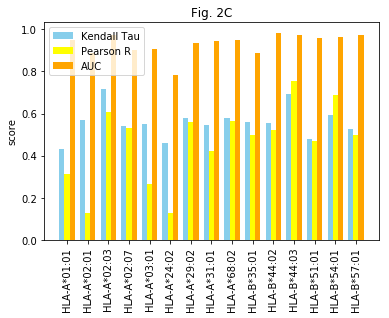

In [37]:
#Plot Fig. 2B

datax=["HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"]

ind = np.arange(len(datax))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width, kendall_tau, width,color='SkyBlue', label='Kendall Tau')
rects2 = ax.bar(ind, pearson_r, width, color='Yellow', label='Pearson R')
rects3 = ax.bar(ind + width, auc, width, color='Orange', label='AUC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('score')
ax.set_title('Fig. 2C')
ax.set_xticks(ind)
ax.set_xticklabels(("HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"), rotation='vertical')
ax.legend()

plt.show()


In [38]:
# Now we will try to see if splitting the results into different classes (high, medium, low, and nonbinders) improves the model or not: 
sample = newd

newd["class"] = False

newd.loc[newd['measurement_value'] <=1, 'class'] = 'high'
newd.loc[(newd['measurement_value'] <=100) & (newd['measurement_value'] >1), 'class'] = 'medium'
newd.loc[(newd['measurement_value'] <=10000) & (newd['measurement_value'] >100), 'class'] = 'low'
newd.loc[newd['measurement_value'] >=10000, 'class'] = 'nonbinders'

newd

/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele,class
79,BoLA-6*13:01,AAVGYPKVKEEML,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301,medium
80,BoLA-6*13:01,AGYPKVKEEML,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301,medium
81,BoLA-6*13:01,AIMPKDIQL,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301,medium
82,BoLA-6*13:01,ALFYKDGKL,1.000000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301,high
83,BoLA-6*13:01,ALYEKKLAL,1.000000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301,high
84,BoLA-6*13:01,AMKDRFQPL,4.300000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301,medium
85,BoLA-6*13:01,APSRTEQTGV,5000.000000,>,qualitative,Srikumaran - cellular MHC/direct/fluorescence,BoLA-6*01301,low
86,BoLA-6*13:01,APVQSLIHSV,5000.000000,>,qualitative,Srikumaran - cellular MHC/direct/fluorescence,BoLA-6*01301,low
87,BoLA-6*13:01,AQRELFFTL,1.000000,=,quantitative,- purified MHC/competitive/fluorescence,BoLA-6*01301,high
88,BoLA-6*13:01,CVGYPKVKEEML,100.000000,<,qualitative,Ellis - cellular MHC/direct/fluorescence,BoLA-6*01301,medium


In [39]:
#predict classes

p_result = predictor.predict_to_dataframe(alleles = sample['allele'], peptides=sample['peptide'])

p_result["class"] = False

p_result.loc[p_result['prediction'] <=1, 'class'] = 'high'
p_result.loc[(p_result['prediction'] <=100) & (p_result['prediction'] >1), 'class'] = 'medium'
p_result.loc[(p_result['prediction'] <=10000) & (p_result['prediction'] >100), 'class'] = 'low'
p_result.loc[p_result['prediction'] >=10000, 'class'] = 'nonbinders'


p_result

,peptide,allele,prediction,prediction_low,prediction_high,prediction_percentile,class
0,AAVGYPKVKEEML,BoLA-6*13:01,3851.831837,46.867887,29891.088309,0.308625,low
1,AGYPKVKEEML,BoLA-6*13:01,602.596120,5.135985,29102.449955,0.025375,low
2,AIMPKDIQL,BoLA-6*13:01,154.216702,6.209612,4842.004053,0.004500,low
3,ALFYKDGKL,BoLA-6*13:01,333.033726,13.093043,10137.765523,0.011500,low
4,ALYEKKLAL,BoLA-6*13:01,112.718503,7.819027,10567.088915,0.003000,low
5,AMKDRFQPL,BoLA-6*13:01,28.882294,2.317477,748.982544,0.000125,medium
6,APSRTEQTGV,BoLA-6*13:01,37471.626732,23221.899163,48905.805964,30.966500,nonbinders
7,APVQSLIHSV,BoLA-6*13:01,26420.863526,3261.892533,48778.364624,9.386875,nonbinders
8,AQRELFFTL,BoLA-6*13:01,40.404553,3.615345,1180.693874,0.000625,medium
9,CVGYPKVKEEML,BoLA-6*13:01,10874.423657,1204.437499,38647.440188,1.539500,nonbinders


In [40]:
#Groupby and count number of alleles predicted to be in each group

true = p_result.groupby("class")["allele"].agg('count').reset_index()
true

,class,allele
0,low,91258
1,medium,40776
2,nonbinders,96535


In [41]:
#Analysis for all data

from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

a = accuracy_score(sample['class'], p_result['class'])
c = confusion_matrix(sample['class'], p_result['class'], labels=['high','medium','low','nonbinders'])

print(a)
print(c)

0.6975836618264069
[[    0  4414   281     7]
 [    0 26435  9111   141]
 [    0  9676 59202 22578]
 [    0   251 22664 73809]]


In [42]:
#Analysis for 15 alleles in paper

alleles = ["HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"]
accuracy = []
confusion = []
f1 = []

for i in range(0,15): 
    allele_data = sample.loc[sample.allele == alleles[i]]
    pred_data = p_result.loc[p_result.allele == alleles[i]]
    accuracy.append(accuracy_score(allele_data['class'], pred_data['class']))
    confusion.append(confusion_matrix(allele_data['class'], pred_data['class']))
    f1.append(f1_score(allele_data['class'], pred_data['class'], average = 'weighted'))
    

print(accuracy)
print(confusion)
print(f1)

/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.6509019990248659, 0.6170368265053392, 0.7139943920469028, 0.5476190476190477, 0.6551075830373929, 0.6198830409356725, 0.67493615468807, 0.6484025559105431, 0.6891873182887996, 0.6468366383380547, 0.7809694793536804, 0.7751677852348994, 0.7945159106296547, 0.7806451612903226, 0.8192148760330579]
[array([[   0,    1,   31,    0],
       [   0, 1153,  190, 1274],
       [   0,  162,  354,    5],
       [   0,  483,    2, 2498]]), array([[   0,   28,  665,    0],
       [   0, 7474, 2144, 3439],
       [   0, 1282, 3350,   19],
       [   0, 1814,   41, 4373]]), array([[   0,    2,  345,    1],
       [   0, 1999,  357,  188],
       [   0,  156, 1859,    3],
       [   0, 1171,   21, 1744]]), array([[31, 15, 21],
       [ 3, 15,  0],
       [18,  0, 23]]), array([[   0,    6,   34,    0],
       [   0, 2801,  498, 1165],
       [   0,  491, 1075,    6],
       [   0, 1095,    7, 2396]]), array([[   0,    4,   60,    0],
       [   0, 1982,  331,  918],
       [   0,  159,  436,    6],


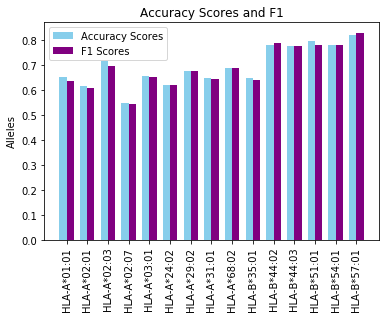

In [43]:
#Plot accuracy scores and f1 scores for 15 alleles

import matplotlib.pyplot as plt
import numpy as np

data_alleles = alleles
data_accuracy = accuracy
data_f1 = f1

ind = np.arange(len(data_alleles))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, data_accuracy, width,
                color='SkyBlue', label='Accuracy Scores')
rects2 = ax.bar(ind + width/2, data_f1, width,
                color='Purple', label='F1 Scores')

ax.set_ylabel('Alleles')
ax.set_title('Accuracy Scores and F1')
ax.set_xticks(ind)
ax.set_xticklabels(("HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"),rotation='vertical')
ax.legend()

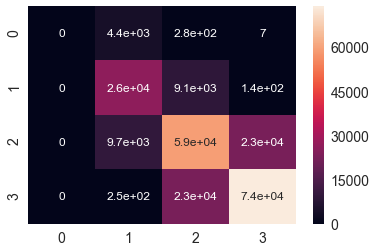

In [44]:
#plot confusion matrix for all of the supported alleles (not just the 15)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = c

df_cm = pd.DataFrame(array, range(4),
                  range(4))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size


In [46]:
#now we will try to see if we can re-train the data and generate same results as authors' trained data:

auc = []
ppv = []
p_coef = []
tau = []
f1 = []
for i in range(0,15):
    Allele_predictor = Class1AffinityPredictor()
    allele_data = df.loc[df.allele == alleles[i]]
    allele_train, allele_test = train_test_split(allele_data,  test_size=0.1)
    Allele_predictor.fit_allele_specific_predictors(n_models=8,architecture_hyperparameters_list=[{"layer_sizes": [16],"max_epochs": 5,"random_negative_constant": 5,}], peptides=allele_train.peptide.values, affinities=allele_train.measurement_value.values, allele=alleles[i])
    Allele_pred = Allele_predictor.predict_to_dataframe(allele_test.peptide, allele=alleles[i])
    Allele_pred.head()
    score = scoring.make_scores(allele_test.measurement_value, Allele_pred.prediction)
    auc.append(score["auc"])
    f1.append(score["f1"])
    tau.append(score["tau"])
    ppv.append(sklearn.metrics.precision_score(allele_test.measurement_value<=500, Allele_pred.prediction<=500))
    p_coef.append(scipy.stats.pearsonr(allele_test.measurement_value, Allele_pred.prediction)[0])
    print(alleles[i])

[ Model  1 /  8, 5537 peptides ]  Epoch   0 /   5: loss=0.204294. Min val loss (None) at epoch None
[ Model  2 /  8, 5537 peptides ]  Epoch   0 /   5: loss=0.200029. Min val loss (None) at epoch None
[ Model  3 /  8, 5537 peptides ]  Epoch   0 /   5: loss=0.195993. Min val loss (None) at epoch None
[ Model  4 /  8, 5537 peptides ]  Epoch   0 /   5: loss=0.197782. Min val loss (None) at epoch None
[ Model  5 /  8, 5537 peptides ]  Epoch   0 /   5: loss=0.210841. Min val loss (None) at epoch None
[ Model  6 /  8, 5537 peptides ]  Epoch   0 /   5: loss=0.209644. Min val loss (None) at epoch None
[ Model  7 /  8, 5537 peptides ]  Epoch   0 /   5: loss=0.203141. Min val loss (None) at epoch None
[ Model  8 /  8, 5537 peptides ]  Epoch   0 /   5: loss=0.192142. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-A*01:01
[ Model  1 /  8, 22166 peptides ]  Epoch   0 /   5: loss=0.150097. Min val loss (None) at epoch None
[ Model  2 /  8, 22166 peptides ]  Epoch   0 /   5: loss=0.156697. Min val loss (None) at epoch None
[ Model  3 /  8, 22166 peptides ]  Epoch   0 /   5: loss=0.153321. Min val loss (None) at epoch None
[ Model  4 /  8, 22166 peptides ]  Epoch   0 /   5: loss=0.156265. Min val loss (None) at epoch None
[ Model  5 /  8, 22166 peptides ]  Epoch   0 /   5: loss=0.158089. Min val loss (None) at epoch None
[ Model  6 /  8, 22166 peptides ]  Epoch   0 /   5: loss=0.147563. Min val loss (None) at epoch None
[ Model  7 /  8, 22166 peptides ]  Epoch   0 /   5: loss=0.156191. Min val loss (None) at epoch None
[ Model  8 /  8, 22166 peptides ]  Epoch   0 /   5: loss=0.150188. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-A*02:01
[ Model  1 /  8, 7061 peptides ]  Epoch   0 /   5: loss=0.223697. Min val loss (None) at epoch None
[ Model  2 /  8, 7061 peptides ]  Epoch   0 /   5: loss=0.213916. Min val loss (None) at epoch None
[ Model  3 /  8, 7061 peptides ]  Epoch   0 /   5: loss=0.221793. Min val loss (None) at epoch None
[ Model  4 /  8, 7061 peptides ]  Epoch   0 /   5: loss=0.229697. Min val loss (None) at epoch None
[ Model  5 /  8, 7061 peptides ]  Epoch   0 /   5: loss=0.216134. Min val loss (None) at epoch None
[ Model  6 /  8, 7061 peptides ]  Epoch   0 /   5: loss=0.223491. Min val loss (None) at epoch None
[ Model  7 /  8, 7061 peptides ]  Epoch   0 /   5: loss=0.21957. Min val loss (None) at epoch None
[ Model  8 /  8, 7061 peptides ]  Epoch   0 /   5: loss=0.223331. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-A*02:03
[ Model  1 /  8,  113 peptides ]  Epoch   0 /   5: loss=0.384051. Min val loss (None) at epoch None
[ Model  2 /  8,  113 peptides ]  Epoch   0 /   5: loss=0.282342. Min val loss (None) at epoch None
[ Model  3 /  8,  113 peptides ]  Epoch   0 /   5: loss=0.390873. Min val loss (None) at epoch None
[ Model  4 /  8,  113 peptides ]  Epoch   0 /   5: loss=0.282019. Min val loss (None) at epoch None
[ Model  5 /  8,  113 peptides ]  Epoch   0 /   5: loss=0.315332. Min val loss (None) at epoch None
[ Model  6 /  8,  113 peptides ]  Epoch   0 /   5: loss=0.33205. Min val loss (None) at epoch None
[ Model  7 /  8,  113 peptides ]  Epoch   0 /   5: loss=0.391106. Min val loss (None) at epoch None
[ Model  8 /  8,  113 peptides ]  Epoch   0 /   5: loss=0.332221. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")
/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


HLA-A*02:07
[ Model  1 /  8, 8616 peptides ]  Epoch   0 /   5: loss=0.198783. Min val loss (None) at epoch None
[ Model  2 /  8, 8616 peptides ]  Epoch   0 /   5: loss=0.195457. Min val loss (None) at epoch None
[ Model  3 /  8, 8616 peptides ]  Epoch   0 /   5: loss=0.200909. Min val loss (None) at epoch None
[ Model  4 /  8, 8616 peptides ]  Epoch   0 /   5: loss=0.191132. Min val loss (None) at epoch None
[ Model  5 /  8, 8616 peptides ]  Epoch   0 /   5: loss=0.190039. Min val loss (None) at epoch None
[ Model  6 /  8, 8616 peptides ]  Epoch   0 /   5: loss=0.198447. Min val loss (None) at epoch None
[ Model  7 /  8, 8616 peptides ]  Epoch   0 /   5: loss=0.190581. Min val loss (None) at epoch None
[ Model  8 /  8, 8616 peptides ]  Epoch   0 /   5: loss=0.195574. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-A*03:01
[ Model  1 /  8, 5232 peptides ]  Epoch   0 /   5: loss=0.200909. Min val loss (None) at epoch None
[ Model  2 /  8, 5232 peptides ]  Epoch   0 /   5: loss=0.203601. Min val loss (None) at epoch None
[ Model  3 /  8, 5232 peptides ]  Epoch   0 /   5: loss=0.205776. Min val loss (None) at epoch None
[ Model  4 /  8, 5232 peptides ]  Epoch   0 /   5: loss=0.201807. Min val loss (None) at epoch None
[ Model  5 /  8, 5232 peptides ]  Epoch   0 /   5: loss=0.210478. Min val loss (None) at epoch None
[ Model  6 /  8, 5232 peptides ]  Epoch   0 /   5: loss=0.207868. Min val loss (None) at epoch None
[ Model  7 /  8, 5232 peptides ]  Epoch   0 /   5: loss=0.204445. Min val loss (None) at epoch None
[ Model  8 /  8, 5232 peptides ]  Epoch   0 /   5: loss=0.210884. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-A*24:02
[ Model  1 /  8, 2466 peptides ]  Epoch   0 /   5: loss=0.246429. Min val loss (None) at epoch None
[ Model  2 /  8, 2466 peptides ]  Epoch   0 /   5: loss=0.24568. Min val loss (None) at epoch None
[ Model  3 /  8, 2466 peptides ]  Epoch   0 /   5: loss=0.260582. Min val loss (None) at epoch None
[ Model  4 /  8, 2466 peptides ]  Epoch   0 /   5: loss=0.241753. Min val loss (None) at epoch None
[ Model  5 /  8, 2466 peptides ]  Epoch   0 /   5: loss=0.255363. Min val loss (None) at epoch None
[ Model  6 /  8, 2466 peptides ]  Epoch   0 /   5: loss=0.243139. Min val loss (None) at epoch None
[ Model  7 /  8, 2466 peptides ]  Epoch   0 /   5: loss=0.255893. Min val loss (None) at epoch None
[ Model  8 /  8, 2466 peptides ]  Epoch   0 /   5: loss=0.261885. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-A*29:02
[ Model  1 /  8, 5634 peptides ]  Epoch   0 /   5: loss=0.217606. Min val loss (None) at epoch None
[ Model  2 /  8, 5634 peptides ]  Epoch   0 /   5: loss=0.20699. Min val loss (None) at epoch None
[ Model  3 /  8, 5634 peptides ]  Epoch   0 /   5: loss=0.21767. Min val loss (None) at epoch None
[ Model  4 /  8, 5634 peptides ]  Epoch   0 /   5: loss=0.216072. Min val loss (None) at epoch None
[ Model  5 /  8, 5634 peptides ]  Epoch   0 /   5: loss=0.210453. Min val loss (None) at epoch None
[ Model  6 /  8, 5634 peptides ]  Epoch   0 /   5: loss=0.215418. Min val loss (None) at epoch None
[ Model  7 /  8, 5634 peptides ]  Epoch   0 /   5: loss=0.212121. Min val loss (None) at epoch None
[ Model  8 /  8, 5634 peptides ]  Epoch   0 /   5: loss=0.217698. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-A*31:01
[ Model  1 /  8, 6500 peptides ]  Epoch   0 /   5: loss=0.225705. Min val loss (None) at epoch None
[ Model  2 /  8, 6500 peptides ]  Epoch   0 /   5: loss=0.216625. Min val loss (None) at epoch None
[ Model  3 /  8, 6500 peptides ]  Epoch   0 /   5: loss=0.217108. Min val loss (None) at epoch None
[ Model  4 /  8, 6500 peptides ]  Epoch   0 /   5: loss=0.219464. Min val loss (None) at epoch None
[ Model  5 /  8, 6500 peptides ]  Epoch   0 /   5: loss=0.203111. Min val loss (None) at epoch None
[ Model  6 /  8, 6500 peptides ]  Epoch   0 /   5: loss=0.217888. Min val loss (None) at epoch None
[ Model  7 /  8, 6500 peptides ]  Epoch   0 /   5: loss=0.215473. Min val loss (None) at epoch None
[ Model  8 /  8, 6500 peptides ]  Epoch   0 /   5: loss=0.217156. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-A*68:02
[ Model  1 /  8, 3812 peptides ]  Epoch   0 /   5: loss=0.225133. Min val loss (None) at epoch None
[ Model  2 /  8, 3812 peptides ]  Epoch   0 /   5: loss=0.226441. Min val loss (None) at epoch None
[ Model  3 /  8, 3812 peptides ]  Epoch   0 /   5: loss=0.231634. Min val loss (None) at epoch None
[ Model  4 /  8, 3812 peptides ]  Epoch   0 /   5: loss=0.229695. Min val loss (None) at epoch None
[ Model  5 /  8, 3812 peptides ]  Epoch   0 /   5: loss=0.229118. Min val loss (None) at epoch None
[ Model  6 /  8, 3812 peptides ]  Epoch   0 /   5: loss=0.219165. Min val loss (None) at epoch None
[ Model  7 /  8, 3812 peptides ]  Epoch   0 /   5: loss=0.236553. Min val loss (None) at epoch None
[ Model  8 /  8, 3812 peptides ]  Epoch   0 /   5: loss=0.233466. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-B*35:01
[ Model  1 /  8, 2005 peptides ]  Epoch   0 /   5: loss=0.232705. Min val loss (None) at epoch None
[ Model  2 /  8, 2005 peptides ]  Epoch   0 /   5: loss=0.228143. Min val loss (None) at epoch None
[ Model  3 /  8, 2005 peptides ]  Epoch   0 /   5: loss=0.237652. Min val loss (None) at epoch None
[ Model  4 /  8, 2005 peptides ]  Epoch   0 /   5: loss=0.232937. Min val loss (None) at epoch None
[ Model  5 /  8, 2005 peptides ]  Epoch   0 /   5: loss=0.237348. Min val loss (None) at epoch None
[ Model  6 /  8, 2005 peptides ]  Epoch   0 /   5: loss=0.228732. Min val loss (None) at epoch None
[ Model  7 /  8, 2005 peptides ]  Epoch   0 /   5: loss=0.23565. Min val loss (None) at epoch None
[ Model  8 /  8, 2005 peptides ]  Epoch   0 /   5: loss=0.233734. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-B*44:02
[ Model  1 /  8, 1341 peptides ]  Epoch   0 /   5: loss=0.236878. Min val loss (None) at epoch None
[ Model  2 /  8, 1341 peptides ]  Epoch   0 /   5: loss=0.245435. Min val loss (None) at epoch None
[ Model  3 /  8, 1341 peptides ]  Epoch   0 /   5: loss=0.265006. Min val loss (None) at epoch None
[ Model  4 /  8, 1341 peptides ]  Epoch   0 /   5: loss=0.250519. Min val loss (None) at epoch None
[ Model  5 /  8, 1341 peptides ]  Epoch   0 /   5: loss=0.281198. Min val loss (None) at epoch None
[ Model  6 /  8, 1341 peptides ]  Epoch   0 /   5: loss=0.250427. Min val loss (None) at epoch None
[ Model  7 /  8, 1341 peptides ]  Epoch   0 /   5: loss=0.237333. Min val loss (None) at epoch None
[ Model  8 /  8, 1341 peptides ]  Epoch   0 /   5: loss=0.25762. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-B*44:03
[ Model  1 /  8, 2658 peptides ]  Epoch   0 /   5: loss=0.218749. Min val loss (None) at epoch None
[ Model  2 /  8, 2658 peptides ]  Epoch   0 /   5: loss=0.22747. Min val loss (None) at epoch None
[ Model  3 /  8, 2658 peptides ]  Epoch   0 /   5: loss=0.215875. Min val loss (None) at epoch None
[ Model  4 /  8, 2658 peptides ]  Epoch   0 /   5: loss=0.232774. Min val loss (None) at epoch None
[ Model  5 /  8, 2658 peptides ]  Epoch   0 /   5: loss=0.22864. Min val loss (None) at epoch None
[ Model  6 /  8, 2658 peptides ]  Epoch   0 /   5: loss=0.228997. Min val loss (None) at epoch None
[ Model  7 /  8, 2658 peptides ]  Epoch   0 /   5: loss=0.215294. Min val loss (None) at epoch None
[ Model  8 /  8, 2658 peptides ]  Epoch   0 /   5: loss=0.217632. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-B*51:01
[ Model  1 /  8, 1116 peptides ]  Epoch   0 /   5: loss=0.273804. Min val loss (None) at epoch None
[ Model  2 /  8, 1116 peptides ]  Epoch   0 /   5: loss=0.252199. Min val loss (None) at epoch None
[ Model  3 /  8, 1116 peptides ]  Epoch   0 /   5: loss=0.259035. Min val loss (None) at epoch None
[ Model  4 /  8, 1116 peptides ]  Epoch   0 /   5: loss=0.267612. Min val loss (None) at epoch None
[ Model  5 /  8, 1116 peptides ]  Epoch   0 /   5: loss=0.258403. Min val loss (None) at epoch None
[ Model  6 /  8, 1116 peptides ]  Epoch   0 /   5: loss=0.263885. Min val loss (None) at epoch None
[ Model  7 /  8, 1116 peptides ]  Epoch   0 /   5: loss=0.262937. Min val loss (None) at epoch None
[ Model  8 /  8, 1116 peptides ]  Epoch   0 /   5: loss=0.258572. Min val loss (None) at epoch None


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


HLA-B*54:01
[ Model  1 /  8, 2613 peptides ]  Epoch   0 /   5: loss=0.215432. Min val loss (None) at epoch None
[ Model  2 /  8, 2613 peptides ]  Epoch   0 /   5: loss=0.208792. Min val loss (None) at epoch None
[ Model  3 /  8, 2613 peptides ]  Epoch   0 /   5: loss=0.22422. Min val loss (None) at epoch None
[ Model  4 /  8, 2613 peptides ]  Epoch   0 /   5: loss=0.221134. Min val loss (None) at epoch None
[ Model  5 /  8, 2613 peptides ]  Epoch   0 /   5: loss=0.222694. Min val loss (None) at epoch None
[ Model  6 /  8, 2613 peptides ]  Epoch   0 /   5: loss=0.224418. Min val loss (None) at epoch None
[ Model  7 /  8, 2613 peptides ]  Epoch   0 /   5: loss=0.224063. Min val loss (None) at epoch None
[ Model  8 /  8, 2613 peptides ]  Epoch   0 /   5: loss=0.234511. Min val loss (None) at epoch None
HLA-B*57:01


/Users/nickiblumenfeld/anaconda3/lib/python3.6/site-packages/mhcflurry/class1_affinity_predictor.py:1027: UserWarning: No percentile rank information available.
  warnings.warn("No percentile rank information available.")


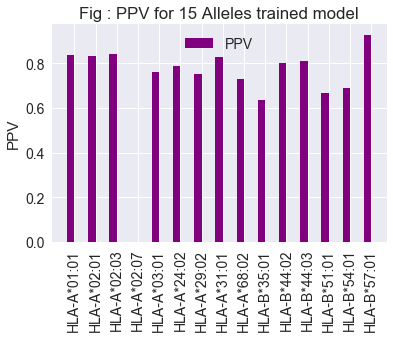

In [47]:
import matplotlib.pyplot as plt
import numpy as np

datax=["HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"]
datay=ppv

ind = np.arange(len(datax))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, datay, width, color='Purple', label='PPV')

ax.set_ylabel('PPV')
ax.set_title('Fig : PPV for 15 Alleles trained model')
ax.set_xticks(ind)
ax.set_xticklabels(("HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"),rotation='vertical')
ax.legend()
plt.show()

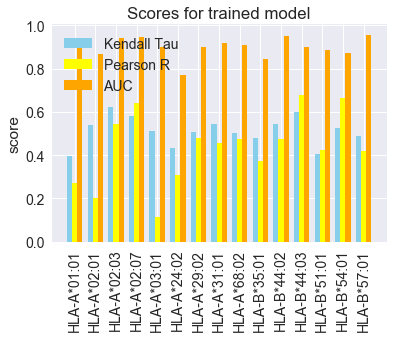

In [48]:
datax=["HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"]

ind = np.arange(len(datax))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width, tau, width,color='SkyBlue', label='Kendall Tau')
rects2 = ax.bar(ind, p_coef, width, color='Yellow', label='Pearson R')
rects3 = ax.bar(ind + width, auc, width, color='Orange', label='AUC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('score')
ax.set_title('Scores for trained model')
ax.set_xticks(ind)
ax.set_xticklabels(("HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"), rotation='vertical')
ax.legend()

plt.show()